In [2]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [5]:
x, y = pkl.load(open('D:/HK6/AI/PROJECTCUOIKI/Detect/samples.pkl', 'rb'))
print(x.shape, y.shape)

roll, pitch, yaw = y[:, 0], y[:, 1], y[:, 2]

(6288, 2278) (6288, 3)


CHIA TẬP DỮ LIỆU ĐỂ TRAIN, TEST, VALIDATION

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [7]:
#chuẩn hóa đối tượng
std = StandardScaler()
std.fit(x_train)
x_train = std.transform(x_train)
x_val = std.transform(x_val)
x_test = std.transform(x_test)

TẠO MODEL

In [10]:
model = Sequential()
model.add(Dense(20, activation='relu', kernel_regularizer='l2', input_dim=x.shape[1]))
model.add(Dense(10, activation='relu', kernel_regularizer='l2'))
model.add(Dense(3, activation='linear'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                45580     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 45,823
Trainable params: 45,823
Non-trainable params: 0
_________________________________________________________________
None


TRAINING

In [24]:
callback_list = [EarlyStopping(monitor='val_loss', patience=25)]

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), batch_size=64, epochs=100, callbacks=callback_list)

Epoch 1/100
69/69 [==============================] - 1s 6ms/step - loss: 74.5186 - val_loss: 49.7544
Epoch 2/100
69/69 [==============================] - 0s 4ms/step - loss: 46.6246 - val_loss: 41.5881
Epoch 3/100
69/69 [==============================] - 0s 3ms/step - loss: 37.8483 - val_loss: 39.3004
Epoch 4/100
69/69 [==============================] - 0s 4ms/step - loss: 38.4977 - val_loss: 41.7234
Epoch 5/100
69/69 [==============================] - 0s 5ms/step - loss: 37.1619 - val_loss: 38.4419
Epoch 6/100
69/69 [==============================] - 0s 4ms/step - loss: 36.9440 - val_loss: 37.9611
Epoch 7/100
69/69 [==============================] - 0s 3ms/step - loss: 33.1214 - val_loss: 35.2161
Epoch 8/100
69/69 [==============================] - 0s 4ms/step - loss: 33.7012 - val_loss: 35.7272
Epoch 9/100
69/69 [==============================] - 0s 5ms/step - loss: 32.4182 - val_loss: 35.3127
Epoch 10/100
69/69 [==============================] - 0s 5ms/step - loss: 36.9359 - val_los

VẼ ĐỒ THỊ NHẬN XÉT

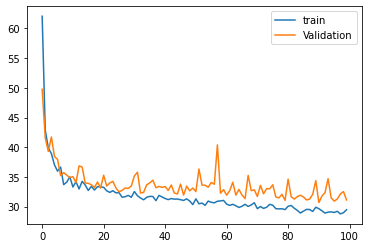

In [25]:
# ve do thi
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','Validation'])
plt.show()

LƯU MODEL

In [26]:
model.save('models/tinhgoc.h5')

Khái niệm Landmarks, có một số thư viện phát hiện các mốc, Dlib có thể tìm thấy 68 landkmark trên mặt.

Ý tưởng cơ bản là tìm 68 điểm cụ thể tồn tại trên mỗi khuôn mặt: đỉnh cằm, mép ngoài của mỗi mắt, mép trong của mỗi lông mày, v.v.

TEST MODEL

In [3]:
def detect_face_points(image):
    detector = dlib.get_frontal_face_detector()
    pred = dlib.shape_predictor("D:\HK6\AI\PROJECTCUOIKI\Detect\shape_predictor_68_face_landmarks.dat")
    face_rect = detector(image, 1)
    if len(face_rect) != 1: return []
    
    dlib_points = pred(image, face_rect[0])
    face_points = []
    for i in range(68):
        x, y = dlib_points.part(i).x, dlib_points.part(i).y
        face_points.append(np.array([x, y]))
    return face_points
        
def compute_features(face_points):
    assert (len(face_points) == 68), "len(face_points) must be 68"
    
    face_points = np.array(face_points)
    features = []
    for i in range(68):
        for j in range(i+1, 68):
            features.append(np.linalg.norm(face_points[i]-face_points[j]))#khoang cách 
            
    return np.array(features).reshape(1, -1)

 X: 0.11°
 Y: -3.31°
 Z: 1.84°


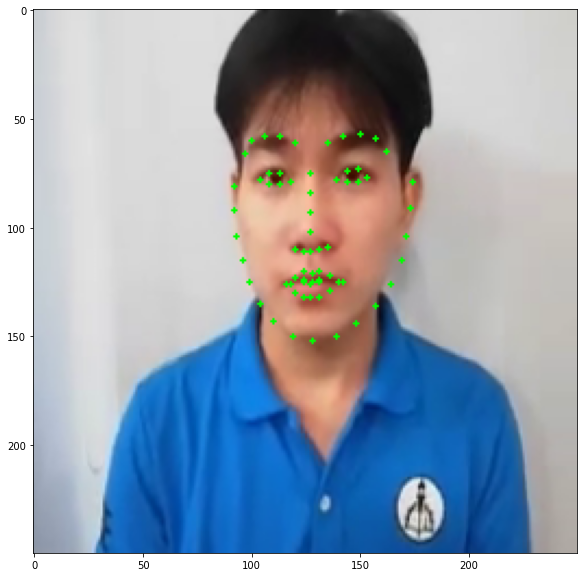

In [9]:
img = cv2.imread('D:\HK6\AI\PROJECTCUOIKI\TEST\THUAN_209.bmp', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
face_points = detect_face_points(img)

for x, y in face_points:
    cv2.circle(img, (x, y), 1, (0, 255, 0), -1)
    
features = compute_features(face_points)
features = std.transform(features)
model = load_model('models/tinhgoc.h5')
y_pred = model.predict(features)

roll_pred, pitch_pred, yaw_pred = y_pred[0]
print(' X: {:.2f}°'.format(roll_pred))
print(' Y: {:.2f}°'.format(pitch_pred))
print(' Z: {:.2f}°'.format(yaw_pred))
    
plt.figure(figsize=(10, 10))
plt.imshow(img)